In [1]:
import importdata
from sklearn.decomposition import PCA
import MachineLearning as ML
import MLAnalysis as MLA
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import scipy.stats as stats
import time

In [2]:
data = importdata.importdata(mask_rad30=True, mask_chisq0=True)
ALL_NAMES = ["gminr", "rminz", "zminw1", "w1minw2", "rmag", "radius", "expscale"]
def z_scale_fn(z):
    return 1+z

/home/alan/mega/AstroTechniques/margaret/notebooks/importdata.py:139: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  catalog = catalog[mask_chisq]


In [7]:
data.columns.values

array(['RELEASE', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR',
       'EBV', 'FLUX_U', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_Y',
       'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_U',
       'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_I', 'FLUX_IVAR_Z',
       'FLUX_IVAR_Y', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3',
       'FLUX_IVAR_W4', 'MW_TRANSMISSION_U', 'MW_TRANSMISSION_G',
       'MW_TRANSMISSION_R', 'MW_TRANSMISSION_I', 'MW_TRANSMISSION_Z',
       'MW_TRANSMISSION_Y', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2',
       'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_U', 'NOBS_G',
       'NOBS_R', 'NOBS_I', 'NOBS_Z', 'NOBS_Y', 'NOBS_W1', 'NOBS_W2',
       'NOBS_W3', 'NOBS_W4', 'RCHISQ_U', 'RCHISQ_G', 'RCHISQ_R',
       'RCHISQ_I', 'RCHISQ_Z', 'RCHISQ_Y', 'RCHISQ_W1', 'RCHISQ_W2',
       'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_U', 'FRACFLUX_G', 'FRACFLUX_R',
       'FRACFLUX_I', 'FRACFLUX_Z', 'FRACFLUX_Y', 'FRACFLUX_W1',
       'FRACFLUX_W2', 'FRACFLUX_

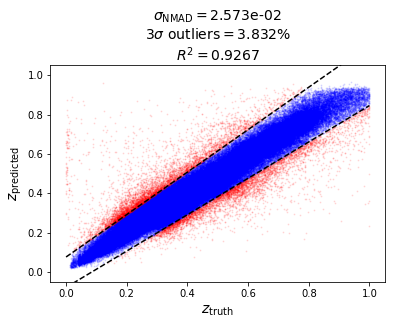

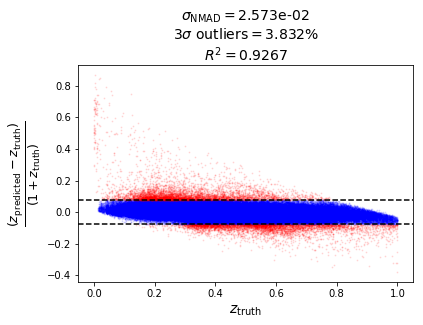

In [4]:
reg = ML.Regressors(data[ALL_NAMES], data["redshift"])
result = reg.RFregressor(max_depth=18, n_estimators=70)
analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=z_scale_fn)
analysis.plot_residuals("z", lambda z: f"(1 + {z})", res=False)
plt.savefig("figs/rf-predict.png", bbox_inches="tight"); plt.show()
analysis.plot_residuals("z", lambda z: f"(1 + {z})")
plt.savefig("figs/rf-residual.png", bbox_inches="tight"); plt.show()

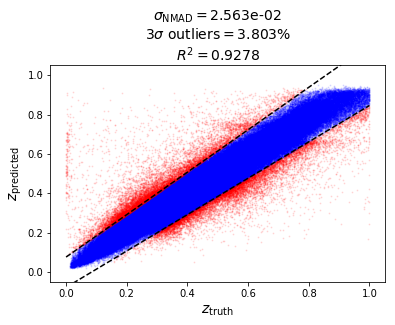

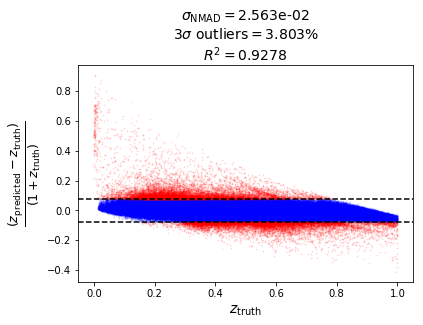

In [29]:
reg = ML.Regressors(data[ALL_NAMES], data["redshift"])
result = reg.RFregressor(max_depth=18, n_estimators=70, cross_validation=True)
analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=z_scale_fn)
analysis.plot_residuals("z", lambda z: f"(1 + {z})", res=False)
plt.savefig("figs/rf-predict-cross-val.png", bbox_inches="tight"); plt.show()
analysis.plot_residuals("z", lambda z: f"(1 + {z})")
plt.savefig("figs/rf-residual-cross-val.png", bbox_inches="tight"); plt.show()

In [ ]:
reg = ML.Regressors(data[ALL_NAMES], data["redshift"])
result = reg.GBregressor(learning_rate=.25, n_estimators=120)
analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=z_scale_fn)
analysis.plot_residuals("z", lambda z: f"(1 + {z})", res=False)
plt.savefig("figs/rf-predict.png", bbox_inches="tight"); plt.show()
analysis.plot_residuals("z", lambda z: f"(1 + {z})")
plt.savefig("figs/rf-residual.png", bbox_inches="tight"); plt.show()

In [ ]:
reg = ML.Regressors(data[ALL_NAMES], data["redshift"])
result = reg.GBregressor(learning_rate=.25, n_estimators=120)
analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=z_scale_fn)
analysis.plot_residuals("z", lambda z: f"(1 + {z})", res=False)
plt.savefig("figs/rf-predict.png", bbox_inches="tight"); plt.show()
analysis.plot_residuals("z", lambda z: f"(1 + {z})")
plt.savefig("figs/rf-residual.png", bbox_inches="tight"); plt.show()

In [30]:
def predict(input_names, target_name, func=ML.Regressors.KNN_dregressor, apply_pca=False, 
            data_slice=slice(None), **kwargs):
    t0 = time.time()
    inputs, target = data[input_names], data[target_name]
    reg = ML.Regressors(inputs, target, apply_pca=apply_pca)
    result = func(reg, **kwargs)
    print(f"Running {func.__name__} took {time.time()-t0} seconds")
    return result, reg

def score(*args, **kwargs):
    result,_ = predict(*args, **kwargs)
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=z_scale_fn)
    score = {
        "r2": analysis.r2(),
        "nmad": analysis.nmad(),
        "outliers": analysis.outlier_frac()
    }
    return score

def all_names_except(leaveout):
    names = ALL_NAMES.copy()
    names.remove(leaveout)
    return names

### Test RF parameters (n_estimators=50, max_depth=18) and GB parameters (n_estimators=100, max_depth=5, learning_rate=0.1)

In [31]:
#gb_results = np.load("figs/gb_results.npy")
#rf_results = np.load("figs/rf_results.npy")

In [ ]:
rf_n_estimators_trials = np.arange(25,76,5)
rf_max_depth_trials = np.arange(11,22)
rf_results = [[score(ALL_NAMES, "redshift", func=ML.Regressors.RFregressor, n_estimators=n_estimators,
                      max_depth=max_depth) for max_depth in rf_max_depth_trials] 
                                     for n_estimators in rf_n_estimators_trials]
np.save("figs/rf_results.npy", rf_results)

gb_n_estimators_trials = np.arange(50,155,10)
gb_learning_rate_trials = np.arange(0.05,0.46,0.05)
gb_results = [[score(ALL_NAMES, "redshift", func=ML.Regressors.GBregressor, n_estimators=n_estimators,
                      learning_rate=learning_rate) for learning_rate in gb_learning_rate_trials] 
                                     for n_estimators in gb_n_estimators_trials]
np.save("figs/gb_results.npy", gb_results)

Running RFregressor took 36.49758529663086 seconds
Running RFregressor took 38.54204249382019 seconds
Running RFregressor took 41.93376350402832 seconds
Running RFregressor took 43.26990246772766 seconds
Running RFregressor took 44.59433960914612 seconds
Running RFregressor took 46.42663359642029 seconds
Running RFregressor took 48.849286794662476 seconds
Running RFregressor took 50.191176652908325 seconds
Running RFregressor took 51.893157720565796 seconds
Running RFregressor took 52.889830589294434 seconds
Running RFregressor took 54.375669956207275 seconds
Running RFregressor took 45.356359243392944 seconds
Running RFregressor took 46.748575925827026 seconds
Running RFregressor took 49.65364480018616 seconds
Running RFregressor took 51.377556800842285 seconds
Running RFregressor took 53.43245339393616 seconds
Running RFregressor took 57.46883797645569 seconds
Running RFregressor took 58.26044273376465 seconds
Running RFregressor took 60.49891209602356 seconds
Running RFregressor too

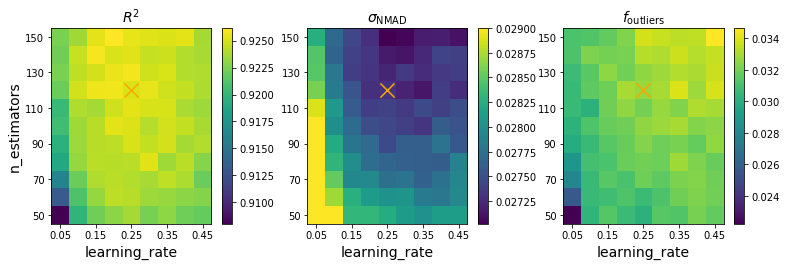

In [22]:
gb_r2 = np.array([[i["r2"] for i in j] for j in gb_results])
gb_nmad = np.array([[i["nmad"] for i in j] for j in gb_results])
gb_outliers = np.array([[i["outliers"] for i in j] for j in gb_results])
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(13,3.6), ncols=3)

cmap = ax0.imshow(gb_r2, origin="lower"); ax0.set_xlabel("learning_rate", fontsize=14); ax0.set_ylabel("n_estimators", fontsize=14)
ax0.xaxis.set_ticklabels([0,.05,.15,.25,.35,.45])
ax0.yaxis.set_ticklabels([0,50,70,90,110,130,150])
cbar = plt.colorbar(cmap, ax=ax0); #cbar.ax.set_xlabel("$R^2$", fontsize=14)

cmap = ax1.imshow(gb_nmad, origin="lower", vmax=.029); ax1.set_xlabel("learning_rate", fontsize=14);
ax1.xaxis.set_ticklabels([0,.05,.15,.25,.35,.45])
ax1.yaxis.set_ticklabels([0,50,70,90,110,130,150])
cbar = plt.colorbar(cmap, ax=ax1); #cbar.ax.set_xlabel("$\\sigma_{\\rm NMAD}$", fontsize=14)

cmap = ax2.imshow(gb_outliers, origin="lower"); ax2.set_xlabel("learning_rate", fontsize=14);
ax2.xaxis.set_ticklabels([0,.05,.15,.25,.35,.45])
ax2.yaxis.set_ticklabels([0,50,70,90,110,130,150])
cbar = plt.colorbar(cmap, ax=ax2); #cbar.ax.set_xlabel("$f_{\\rm outliers}$", fontsize=14);
ax0.set_title("$R^2$",fontsize=14); ax1.set_title("$\\sigma_{\\rm NMAD}$",fontsize=14); ax2.set_title("$f_{\\rm outliers}$",fontsize=14)

[ax.scatter(4,7,color="orange",marker="x",s=200) for ax in [ax0,ax1,ax2]]
plt.savefig("figs/gb-scoring.png", bbox_inches="tight")

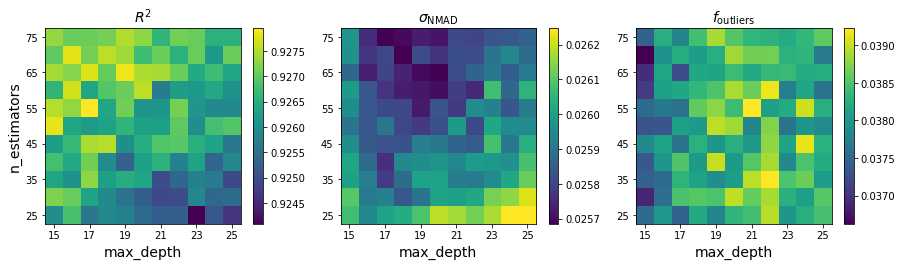

In [56]:
rf_r2 = np.array([[i["r2"] for i in j] for j in rf_results])
rf_nmad = np.array([[i["nmad"] for i in j] for j in rf_results])
rf_outliers = np.array([[i["outliers"] for i in j] for j in rf_results])
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(15,3.6), ncols=3)

cmap = ax0.imshow(rf_r2, origin="lower"); ax0.set_xlabel("max_depth", fontsize=14); ax0.set_ylabel("n_estimators", fontsize=14)
ax0.xaxis.set_ticklabels([0,15,17,19,21,23,25])
ax0.yaxis.set_ticklabels([0,25,35,45,55,65,75])
cbar = plt.colorbar(cmap, ax=ax0); #cbar.ax.set_xlabel("$R^2$", fontsize=14)

cmap = ax1.imshow(rf_nmad, origin="lower"); ax1.set_xlabel("max_depth", fontsize=14);
ax1.xaxis.set_ticklabels([0,15,17,19,21,23,25])
ax1.yaxis.set_ticklabels([0,25,35,45,55,65,75])
cbar = plt.colorbar(cmap, ax=ax1); #cbar.ax.set_xlabel("$\\sigma_{\\rm NMAD}$", fontsize=14)

cmap = ax2.imshow(rf_outliers, origin="lower"); ax2.set_xlabel("max_depth", fontsize=14);
ax2.xaxis.set_ticklabels([0,15,17,19,21,23,25])
ax2.yaxis.set_ticklabels([0,25,35,45,55,65,75])
cbar = plt.colorbar(cmap, ax=ax2); #cbar.ax.set_xlabel("$f_{\\rm outliers}$", fontsize=14);
ax0.set_title("$R^2$",fontsize=14); ax1.set_title("$\\sigma_{\\rm NMAD}$",fontsize=14); ax2.set_title("$f_{\\rm outliers}$",fontsize=14)
plt.savefig("figs/rf-scoring.png", bbox_inches="tight")

### Test each regressor, with and without PCA, to determine which is the best

In [79]:
funcs = [ML.Regressors.RFregressor, 
         ML.Regressors.KNN_dregressor, 
         ML.Regressors.GBregressor, 
         ML.Regressors.Xgboostregressor]
best_results_pca = []
best_results = []
for func in fun
    best_results_pca.append(predict(ALL_NAMES, "redshift", func=func, 
                                    apply_pca=True, cross_validation=True))
    best_results.append(predict(ALL_NAMES, "redshift", func=func, 
                                    apply_pca=False, cross_validation=True))

Running RFregressor took 980.4264924526215 seconds
Running RFregressor took 968.0869839191437 seconds
Running KNN_dregressor took 137.60170888900757 seconds
Running KNN_dregressor took 135.59103655815125 seconds
Running GBregressor took 809.4325215816498 seconds
Running GBregressor took 791.7341785430908 seconds


/home/alan/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Running Xgboostregressor took 858.0984725952148 seconds


/home/alan/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Running Xgboostregressor took 851.0949003696442 seconds


In [78]:
ALL_NAMES

['gminr', 'rminz', 'zminw1', 'w1minw2', 'rmag', 'radius', 'expscale']

### Test leaving out one feature at a time

In [8]:
input_names_trials = [all_names_except(name) for name in ALL_NAMES]
target_name = "redshift"

results = [predict(names, target_name) for names in input_names_trials]

Running KNN_dregressor took 37.90912652015686 seconds
Running KNN_dregressor took 38.848461627960205 seconds
Running KNN_dregressor took 34.20181608200073 seconds
Running KNN_dregressor took 33.320144176483154 seconds
Running KNN_dregressor took 34.36817002296448 seconds
Running KNN_dregressor took 34.2250452041626 seconds
Running KNN_dregressor took 20.935343265533447 seconds


NameError: name 'results_pca' is not defined

In [9]:
input_names_trials = [all_names_except(name) for name in ALL_NAMES]
target_name = "redshift"

results_pca = [predict(names, target_name, apply_pca=True) for names in input_names_trials]

Running KNN_dregressor took 34.984288454055786 seconds
Running KNN_dregressor took 30.086834192276 seconds
Running KNN_dregressor took 33.47538924217224 seconds
Running KNN_dregressor took 31.667632579803467 seconds
Running KNN_dregressor took 33.96467471122742 seconds
Running KNN_dregressor took 34.15888690948486 seconds
Running KNN_dregressor took 21.21702218055725 seconds


In [134]:
def f(z):
    return 1+z
for result,reg in [*best_results, *best_results_pca]:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    reg.test = {
        "r2": analysis.r2(),
        "nmad": analysis.nmad(),
        "outliers": analysis.outlier_frac()
    }

[7.453535369561504e-05, 0.0, -2.9023100703851057e-06, 0.0]
[1.8937542265735907e-05, 0.0, -7.28734076860249e-07, 0.0]
[-0.0002583390629004728, 0.0, 4.068331699219607e-06, 0.0]
No PCA:


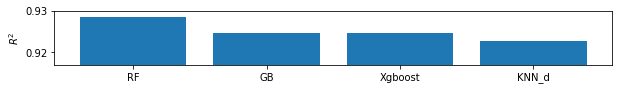

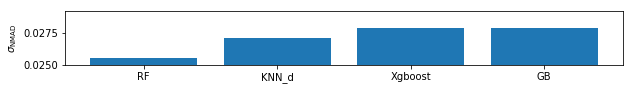

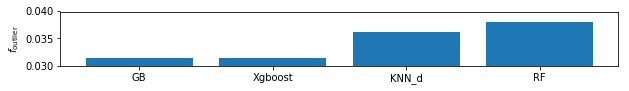

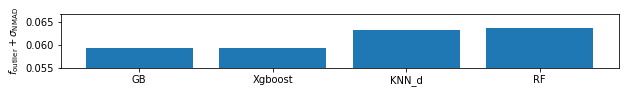

With PCA:


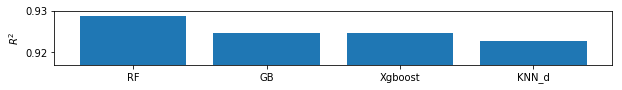

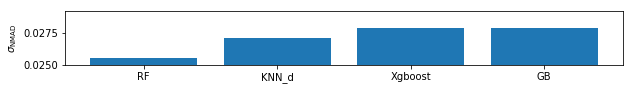

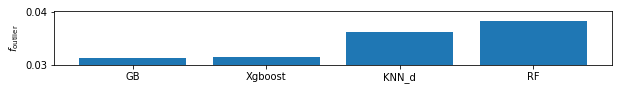

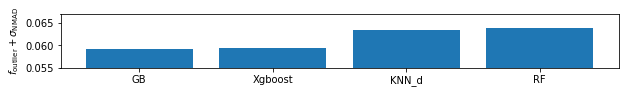

In [143]:
def plot_best_results(results):
    results, regs = zip(*results)
    x = np.array(["RF", "KNN_d", "GB", "Xgboost"])
    argr = np.argsort([reg.test["r2"] for reg in regs])[::-1]
    argn = np.argsort([reg.test["nmad"] for reg in regs])
    argo = np.argsort([reg.test["outliers"] for reg in regs])
    arg2 = np.argsort([reg.test["outliers"] + reg.test["nmad"] for reg in regs])

    plt.figure(figsize=(10,1))
    plt.bar(x[argr],np.array([reg.test["r2"] for reg in regs])[argr]); plt.ylim([.917,.93]); plt.ylabel("$R^2$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argn],np.array([reg.test["nmad"] for reg in regs])[argn]); plt.ylim(bottom=.025); plt.ylabel("$\\sigma_{\\rm NMAD}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] for reg in regs])[argo]); plt.ylim(bottom=.03); plt.ylabel("$f_{\\rm outlier}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] + reg.test["nmad"] for reg in regs])[arg2]); plt.ylim(bottom=.055); plt.ylabel("$f_{\\rm outlier} + \\sigma_{\\rm NMAD}$")

print([result_pca[1].test["r2"]-result[1].test["r2"] for (result,result_pca) in zip(best_results,best_results_pca)])
print([result[1].test["nmad"]-result_pca[1].test["nmad"] for (result,result_pca) in zip(best_results,best_results_pca)])
print([result[1].test["outliers"]-result_pca[1].test["outliers"] for (result,result_pca) in zip(best_results,best_results_pca)])
print("No PCA:")
plot_best_results(best_results); plt.show()
print("With PCA:")
plot_best_results(best_results_pca)

[-0.0010126244111698934, -0.0006118801099159743, 2.7907072423394297e-05, -3.178550325999563e-05, 0.0003752332594736396, -0.000891883882220057, -0.000742007902778119]
[4.196067589108676e-05, -5.308390424756809e-05, 5.128597525772688e-05, -8.729292695106722e-06, -4.761831322731835e-06, -3.2931850555556474e-08, 8.729771780003476e-05]
[0.00017086993136724432, 0.00015866493626957856, -0.0005044731307032868, 0.00017493826306646393, 0.00020341658496100812, -2.4409990195324582e-05, -0.0006021130914845713]
No PCA:


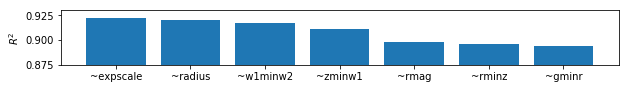

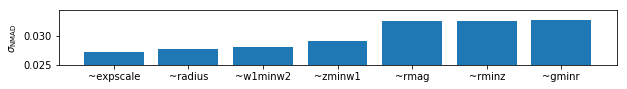

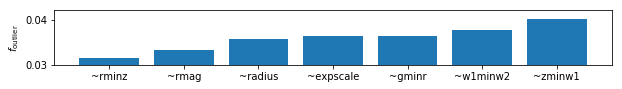

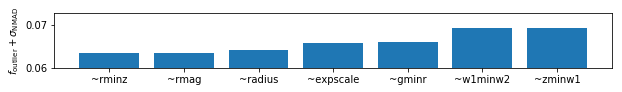

With PCA:


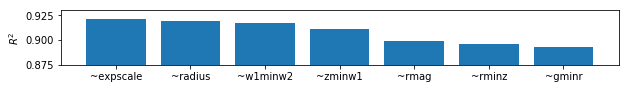

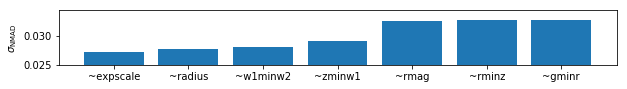

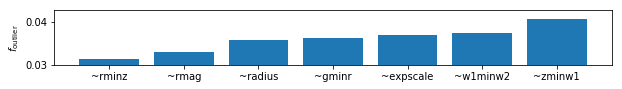

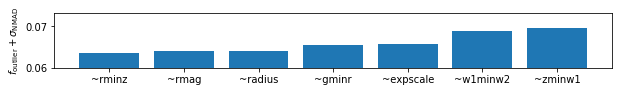

In [17]:
def plot_results(results):
    results, regs = zip(*results)
    x = np.array(["~"+name for name in ALL_NAMES] + ["all"])
    argr = np.argsort([reg.test["r2"] for reg in regs])[::-1]
    argn = np.argsort([reg.test["nmad"] for reg in regs])
    argo = np.argsort([reg.test["outliers"] for reg in regs])
    arg2 = np.argsort([reg.test["outliers"] + reg.test["nmad"] for reg in regs])

    plt.figure(figsize=(10,1))
    plt.bar(x[argr],np.array([reg.test["r2"] for reg in regs])[argr]); plt.ylim([.875,.93]); plt.ylabel("$R^2$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argn],np.array([reg.test["nmad"] for reg in regs])[argn]); plt.ylim(bottom=.025); plt.ylabel("$\\sigma_{\\rm NMAD}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] for reg in regs])[argo]); plt.ylim(bottom=.03); plt.ylabel("$f_{\\rm outlier}$")
    plt.figure(figsize=(10,1))
    plt.bar(x[argo],np.array([reg.test["outliers"] + reg.test["nmad"] for reg in regs])[arg2]); plt.ylim(bottom=.06); plt.ylabel("$f_{\\rm outlier} + \\sigma_{\\rm NMAD}$")

print([result_pca[1].test["r2"]-result[1].test["r2"] for (result,result_pca) in zip(results,results_pca)])
print([result[1].test["nmad"]-result_pca[1].test["nmad"] for (result,result_pca) in zip(results,results_pca)])
print([result[1].test["outliers"]-result_pca[1].test["outliers"] for (result,result_pca) in zip(results,results_pca)])
print("No PCA:")
plot_results(results); plt.show()
print("With PCA:")
plot_results(results_pca)

# Below is the result obtained without selecting radius < 30

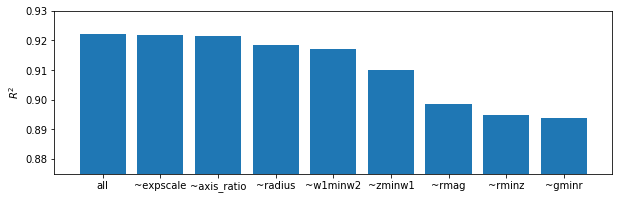

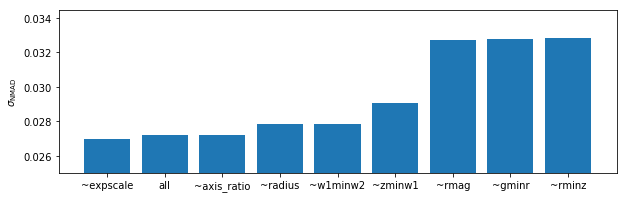

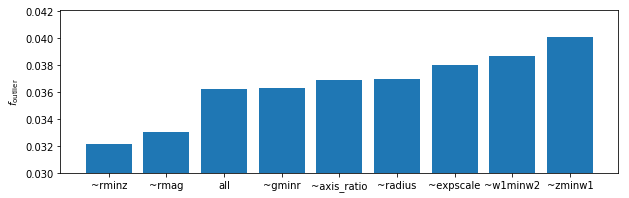

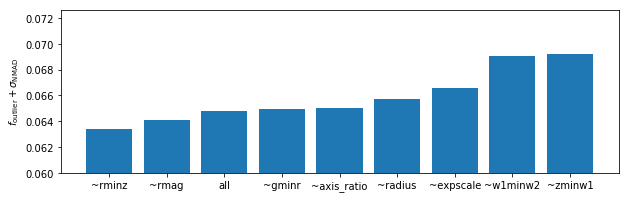

In [62]:
x = np.array(["~"+name for name in ALL_NAMES] + ["all"])
argr = np.argsort([result["r2"][0] for result in results])[::-1]
argn = np.argsort([result["nmad"][0] for result in results])
argo = np.argsort([result["outliers"][0] for result in results])
arg2 = np.argsort([result["outliers"][0] + result["nmad"][0] for result in results])

plt.figure(figsize=(10,3))
plt.bar(x[argr],np.array([result["r2"][0] for result in results])[argr]); plt.ylim([.875,.93]); plt.ylabel("$R^2$")
plt.figure(figsize=(10,3))
plt.bar(x[argn],np.array([result["nmad"][0] for result in results])[argn]); plt.ylim(bottom=.025); plt.ylabel("$\\sigma_{\\rm NMAD}$");
plt.figure(figsize=(10,3))
plt.bar(x[argo],np.array([result["outliers"][0] for result in results])[argo]); plt.ylim(bottom=.03); plt.ylabel("$f_{\\rm outlier}$");
plt.figure(figsize=(10,3))
plt.bar(x[argo],np.array([result["outliers"][0] + result["nmad"][0] for result in results])[arg2]); plt.ylim(bottom=.06); plt.ylabel("$f_{\\rm outlier} + \\sigma_{\\rm NMAD}$");

Running RFregressor took 93.53373432159424 seconds
Running KNNregressor took 18.17453694343567 seconds
Running KNN_dregressor took 19.28568983078003 seconds


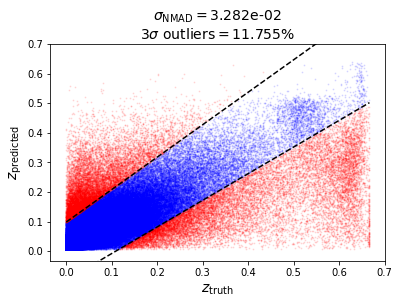

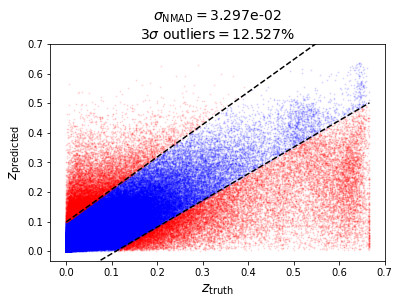

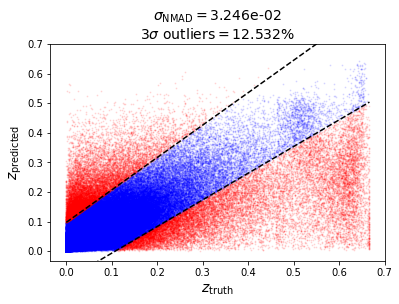

In [27]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "prob_exp"]
target_name = "b1000"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func, data_slice=mask_chisq) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 103.13085603713989 seconds
Running KNNregressor took 6.745930433273315 seconds
Running KNN_dregressor took 31.172248601913452 seconds


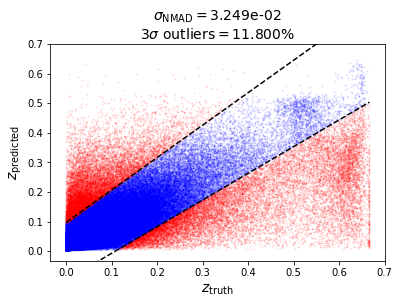

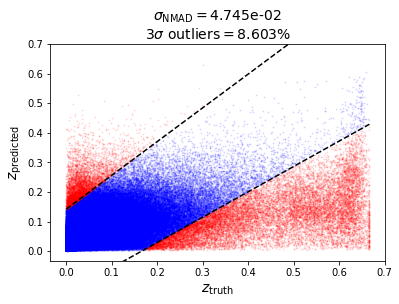

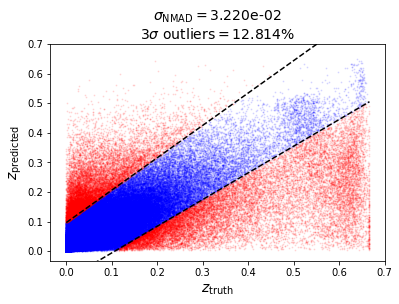

In [28]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "expscale"]
target_name = "b1000"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 95.89278054237366 seconds
Running KNNregressor took 12.307918310165405 seconds
Running KNN_dregressor took 23.21302628517151 seconds


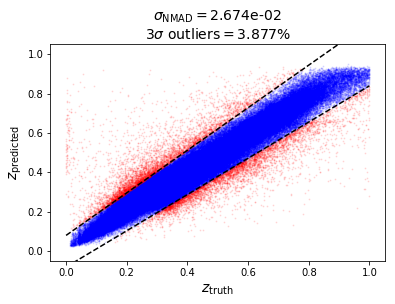

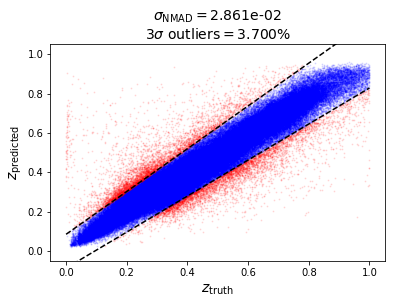

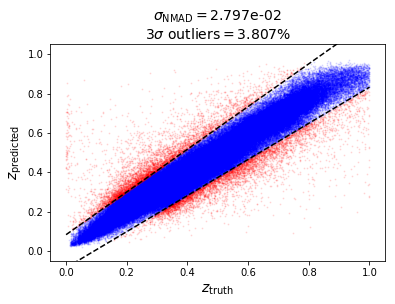

In [20]:
input_names = ["gminr", "rminz", "zminw1", "w1minw2", "gmag", "p_exp"]
target_name = "redshift"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

Running RFregressor took 88.39898228645325 seconds
Running KNNregressor took 13.181779384613037 seconds
Running KNN_dregressor took 16.232118606567383 seconds


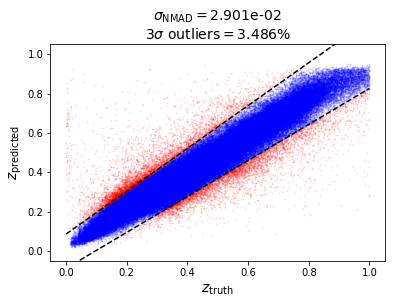

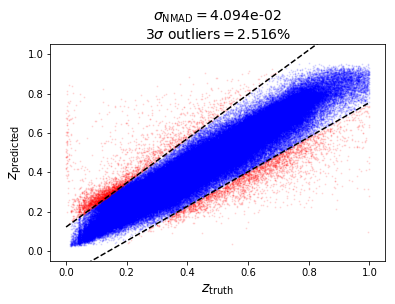

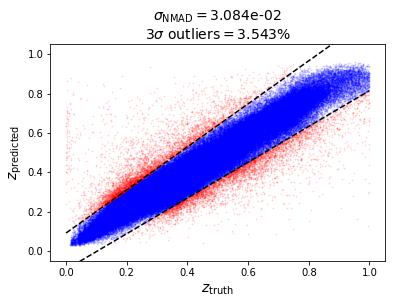

In [21]:
input_names = ["gmag", "rmag", "zmag", "w1mag", "w2mag", "logprob_exp"]
target_name = "redshift"

funcs = [ML.Regressors.RFregressor, ML.Regressors.KNNregressor, ML.Regressors.KNN_dregressor]
results = [predict(input_names, target_name, func) for func in funcs]

def f(z):
    ans = z.copy()
    ans[z < 0.5] = (1 - z[z < 0.5])**3/(1-.5)**3*.5
    return 1+z
f_label = lambda target: f"(1 + {target})"
target_label = "z"
for result in results:
    analysis = MLA.RegressionAnalyzer(result["predict"], result["test"], scale_as=f)
    plt.figure()
    analysis.plot_residuals(target_label, f_label, res=False)

# Selection Plots

In [ ]:
alldata = importdata.importdata(mask_stars=False)

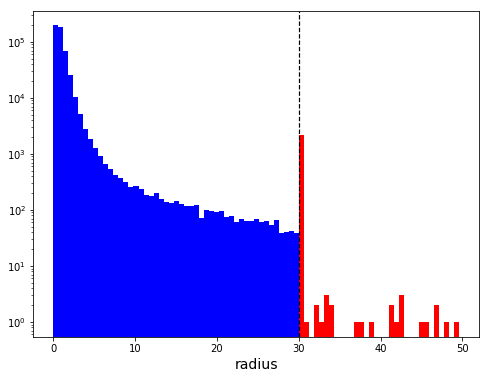

In [58]:
goodbins = np.linspace(0,30,50)
badbins = np.arange(goodbins[-1], 50, np.diff(goodbins)[-1])

plt.figure(figsize=(8,6))
plt.hist(alldata.radius, bins=goodbins, color="blue")
plt.hist(alldata.radius, bins=badbins, color="red")

plt.xlabel("radius", fontsize=14)
plt.axvline(30, color="k", ls="--", lw=1.2)
plt.semilogy();
plt.savefig("figs/radius-selection.png", bbox_inches="tight")

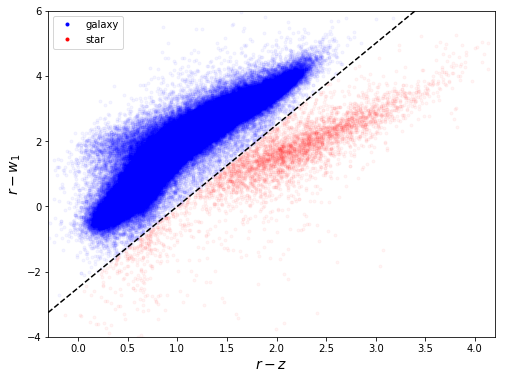

In [35]:
def plot_line(m,b):
    x = np.linspace(-1,4)
    y = m*x + b
    plt.plot(x,y,"k--")

x,y = alldata["rmag"]-alldata["zmag"], alldata["rmag"]-alldata["w1mag"]
is_star = y < 2.5 * x - 2.5

plt.figure(figsize=(8,6))
plt.plot(x[is_star],y[is_star], "r.", alpha=.04)
plt.plot(x[~is_star],y[~is_star], "b.", alpha=.04)
plt.plot([],[], "b.", label="galaxy")
plt.plot([],[], "r.", label="star")

plt.xlabel("$r-z$", fontsize=14); plt.ylabel("$r-w_1$", fontsize=14)
plt.xlim([-.3,4.2]); plt.ylim([-4,6])
plot_line(2.5,-2.5); plt.legend();
plt.savefig("figs/star-mask.png", bbox_inches="tight")

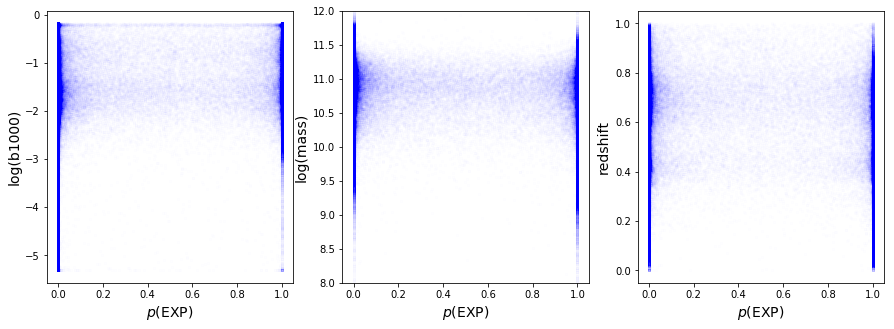

In [101]:
fig,axes = plt.subplots(figsize=(15,5), ncols=3)
[ax.set_xlabel("$p(\\rm EXP)$", fontsize=14) for ax in axes]
axes[0].plot(data.prob_exp, np.log10(data.b1000), "b.", alpha=.005); axes[0].set_ylabel("log(b1000)", fontsize=14)
axes[1].plot(data.prob_exp, data.mass_ir, "b.", alpha=.005); axes[1].set_ylabel("log(mass)", fontsize=14)
axes[2].plot(data.prob_exp, data.redshift, "b.", alpha=.005); axes[2].set_ylabel("redshift", fontsize=14);
axes[1].set_ylim([8,12])
plt.savefig("figs/prob-vs-targets.png", bbox_inches="tight")

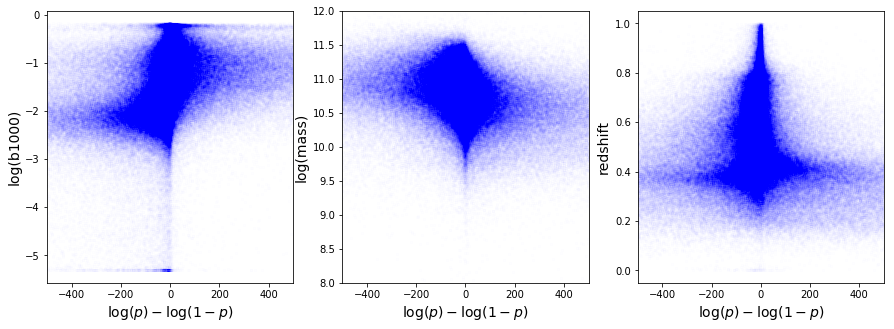

In [100]:
fig,axes = plt.subplots(figsize=(15,5), ncols=3)
[ax.set_xlim((-500,500)) for ax in axes]
[ax.set_xlabel("$\\log(p)-\\log(1-p)$", fontsize=14) for ax in axes]
axes[0].plot(data.expscale, np.log10(data.b1000), "b.", alpha=.005); axes[0].set_ylabel("log(b1000)", fontsize=14)
axes[1].plot(data.expscale, data.mass_ir, "b.", alpha=.005); axes[1].set_ylabel("log(mass)", fontsize=14)
axes[2].plot(data.expscale, data.redshift, "b.", alpha=.005); axes[2].set_ylabel("redshift", fontsize=14);
axes[1].set_ylim([8,12])
plt.savefig("figs/scale-vs-targets.png", bbox_inches="tight")

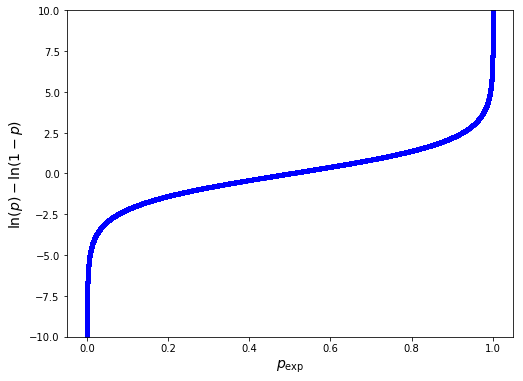

In [102]:
plt.figure(figsize=(8,6))
plt.plot(data.prob_exp, data.expscale, "b."); plt.ylim([-10,10]); plt.xlabel("$p_{\\rm exp}$", fontsize=14)
plt.ylabel("$\\ln(p)-\\ln(1-p)$", fontsize=14);
plt.savefig("figs/double-log-scaling.png")

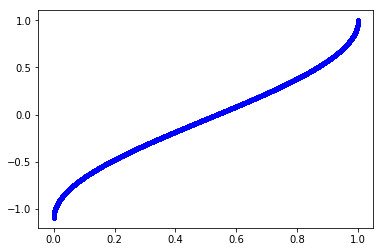

In [99]:
expjeffp = 1. - 4./3.*np.arcsin(np.sqrt(1-data.prob_exp))
plt.plot(data.prob_exp, expjeffp, "b."); plt.show()

In [61]:
ALL_NAMES
all_labels = ["$g-r$", "$r-z$", "$z-w_1$", "$w_1-w_2$", "$r$", "radius", "$\\log(p) - \\log(1-p)$"]

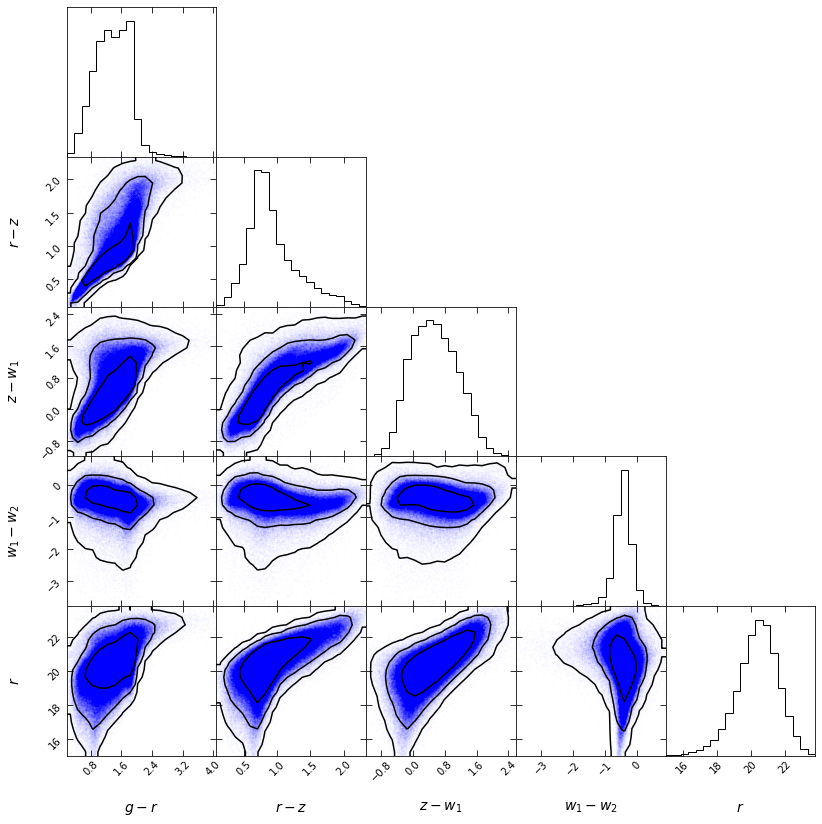

In [90]:
fig = corner.corner(data[data.radius<30][ALL_NAMES[:-2]].values, no_fill_contours=True, plot_density=False, labels=all_labels, 
              label_kwargs={"fontsize":14}, range=[.999,.999,.999,.999,.999],#,.99,.97], 
              data_kwargs={"alpha":.01, "color":"blue"}, levels=[.68,.95,.995]);
fig.subplots_adjust(hspace=0, wspace=0)
[ax.tick_params(which="both", direction="in", length=6, 
                bottom=True, top=True, left=True, right=True) for ax in fig.axes]
[ax.tick_params(which="both", left=False, right=False) for ax in fig.axes[::1+int(np.sqrt(len(fig.axes)))]]
plt.savefig("figs/colors-corner.png", bbox_inches="tight")

In [68]:
pca = PCA()
pca = PCA(n_components=len(ALL_NAMES[:-2]))
principalComponents = pca.fit_transform(data[data.radius<30][ALL_NAMES[:-2]].values)

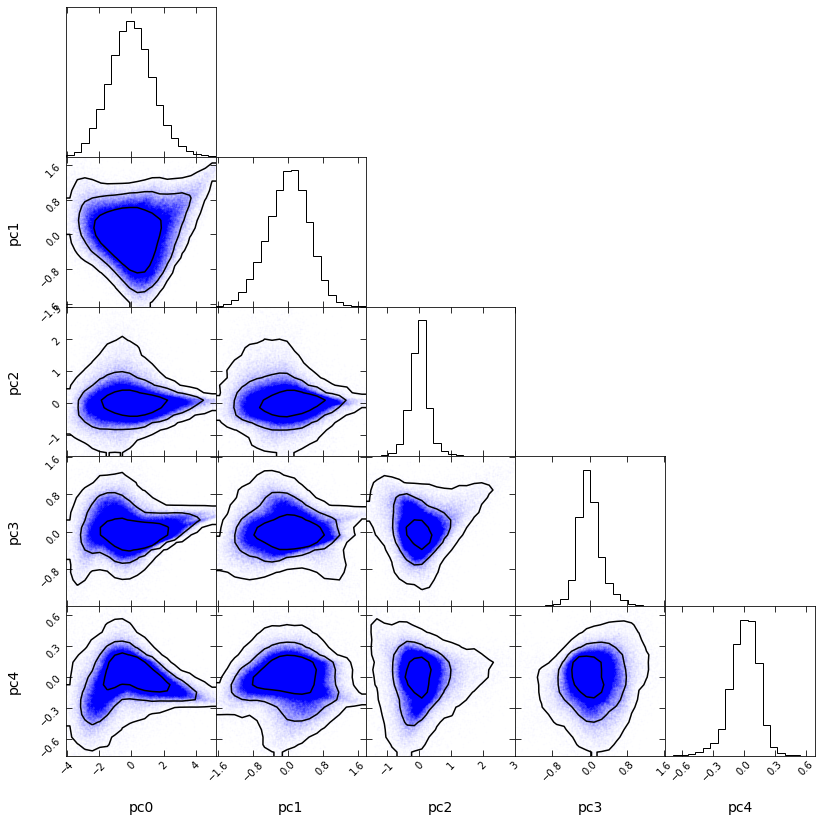

In [91]:
#principalComponents = pca.transform(data[data.radius<30][ALL_NAMES].values)
fig = corner.corner(principalComponents, no_fill_contours=True, plot_density=False, 
              labels=[f"pc{i}" for i in range(len(ALL_NAMES))], label_kwargs={"fontsize":14}, 
              range=[.999,.999,.999,.999,.999], data_kwargs={"alpha":.01, "color":"blue"},
              levels=[.68,.95,.995]);
fig.subplots_adjust(hspace=0, wspace=0)
[ax.tick_params(which="both", direction="in", length=6, 
                bottom=True, top=True, left=True, right=True) for ax in fig.axes]
[ax.tick_params(which="both", left=False, right=False) for ax in fig.axes[::1+int(np.sqrt(len(fig.axes)))]]
plt.savefig("figs/pc-corner.png", bbox_inches="tight")

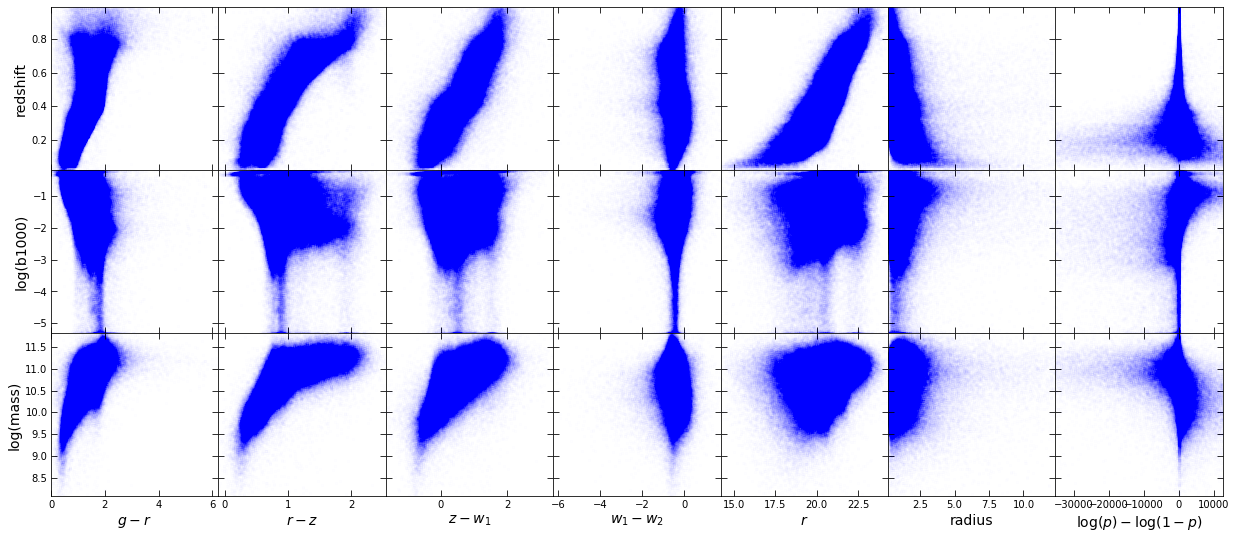

In [83]:
ZRANGE = np.percentile(data.redshift, [.05, 99.95])
MRANGE = np.percentile(np.log10(data.b1000), [.05, 99.95])
BRANGE = np.percentile(data.mass_ir, [.05, 99.95])
def plot_feature(feature, name, axes, range):
    dq = (1-range)*50.
    xrange = np.percentile(feature, [dq, 100-dq])
    [ax.set_xlim(xrange) for ax in axes]
    axes[0].plot(feature, data.redshift, "b.", alpha=.005); axes[0].set_ylim(ZRANGE)
    axes[1].plot(feature, np.log10(data.b1000), "b.", alpha=.005); axes[1].set_ylim(MRANGE)
    axes[2].plot(feature, data.mass_ir, "b.", alpha=.005); axes[2].set_ylim(BRANGE)

def make_feature_plot(features, names, labels=None, ranges=None):
    labels = names if (labels is None) else labels
    ranges = [.999] * len(features) if ranges is None else ranges
    fig,axes = plt.subplots(figsize=(3*len(features),9), nrows=3, ncols=(len(features)), 
                            gridspec_kw={"hspace":0, "wspace":0})
    axes[0,0].set_ylabel("redshift", fontsize=14)
    axes[1,0].set_ylabel("log(b1000)", fontsize=14)
    axes[2,0].set_ylabel("log(mass)", fontsize=14)
    [[axes[i,j].tick_params(which="both", direction="in", length=6, 
                            bottom=True, top=True, left=True, right=True)
                            for i in range(3)] for j in range(len(features))]
    [axes[-1,i].set_xlabel(f"{labels[i]}", fontsize=14) for i in range(len(features))]
    [[axes[i,j].xaxis.set_major_formatter(plt.NullFormatter()) for i in range(2)] for j in range(len(features))]
    [[axes[i,j].yaxis.set_major_formatter(plt.NullFormatter()) for i in range(3)] for j in range(1,len(features))]
    for i in range(len(features)):
        plot_feature(features[i], names[i], axes[:,i], ranges[i])

make_feature_plot(data[ALL_NAMES].values.T, ALL_NAMES, labels=all_labels, ranges=[.9999, .9999, .9999, .9999, .9999, .99, .97])
plt.savefig("figs/features-vs-targets.png", bbox_inches="tight")

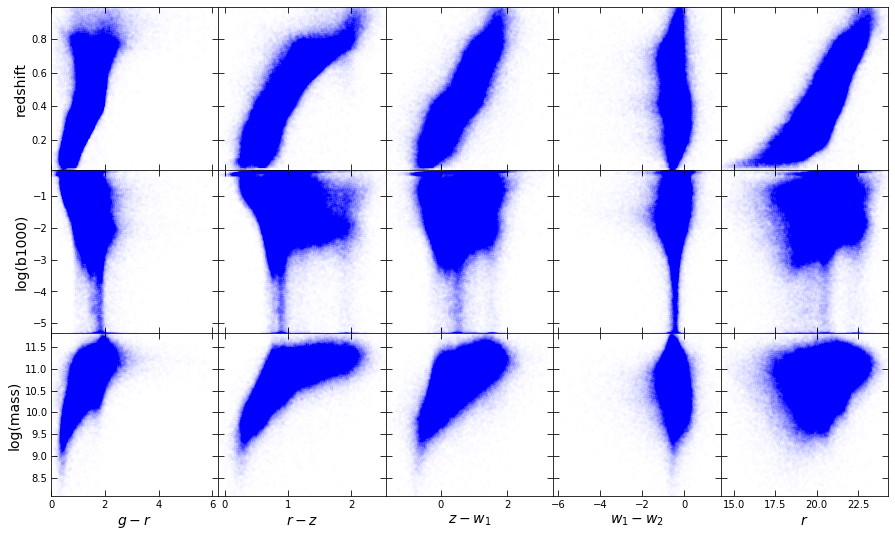

In [84]:
make_feature_plot(data[ALL_NAMES[:-2]].values.T, ALL_NAMES[:-2], labels=all_labels[:-2], ranges=[.9999, .9999, .9999, .9999, .9999])
plt.savefig("figs/colors-vs-targets.png", bbox_inches="tight")

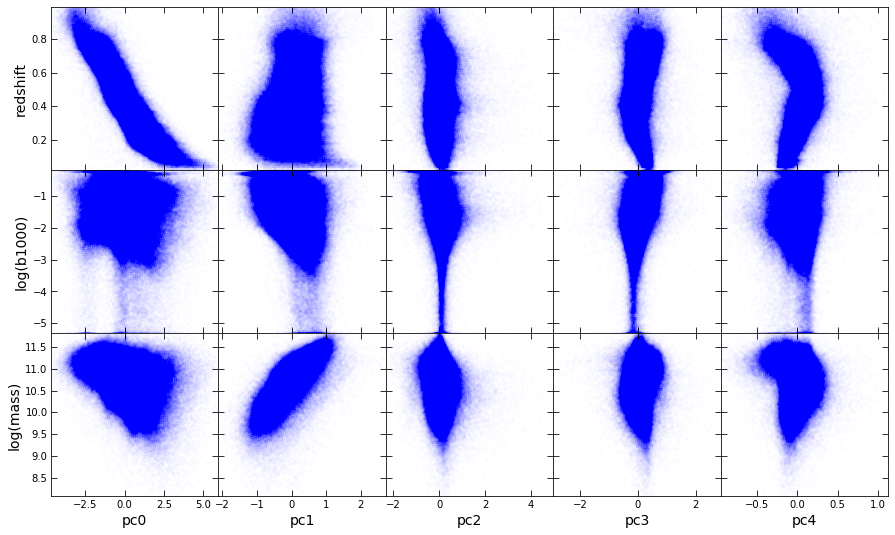

In [85]:
make_feature_plot(principalComponents.T, [f"pc{i}" for i in range(5)], ranges=[.9999, .9999, .9999, .9999, .9999])
plt.savefig("figs/pc-vs-targets.png", bbox_inches="tight")

$$
p(\text{EXP} | \text{EXP or DEV})  \approx \frac{L_\text{EXP}^\text{max}}{ L_\text{EXP}^\text{max} + L_\text{DEV}^\text{max}} = \frac{e^{-\frac{1}{2} \chi_\text{EXP}^2}}{e^{-\frac{1}{2} \chi_\text{EXP}^2} + e^{-\frac{1}{2}\chi^2_\text{DEV}}}
$$

In [160]:
data = data[data.radius<30]